# EDA & Funnel Analysis

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

#  Load and clean data
events1 = pd.read_csv('events1.csv', parse_dates=['date'])
items = pd.read_csv('items.csv')
users = pd.read_csv('users.csv', dtype={'date': 'object'})  # Read as string

#  Convert 'date' column in users to datetime explicitly
users['date'] = pd.to_datetime(users['date'], format='%d-%m-%Y %H:%M', dayfirst=True, errors='coerce')

#  Clean column names
for df, name in [(events1, 'events1'), (items, 'items'), (users, 'users')]:
    df.columns = df.columns.str.strip().str.lower()


In [ ]:
#  Aggregate session-level metrics
session_agg = events1.groupby('ga_session_id').agg(
    user_id=('user_id', 'first'),
    country=('country', 'first'),
    device=('device', 'first'),
    session_start=('date', 'min'),
    session_end=('date', 'max'),
    events_count=('type', 'count'),
    add_to_cart_count=('type', lambda x: (x == 'add_to_cart').sum()),
    begin_checkout_count=('type', lambda x: (x == 'begin_checkout').sum()),
    purchase_count=('type', lambda x: (x == 'purchase').sum())
).reset_index()


#  Add conversion flag
session_agg['converted'] = session_agg['purchase_count'] > 0

#  Calculate session duration
session_agg['session_start'] = pd.to_datetime(session_agg['session_start'], errors='coerce')
session_agg['session_end'] = pd.to_datetime(session_agg['session_end'], errors='coerce')
session_agg['session_duration_seconds'] = (
    session_agg['session_end'] - session_agg['session_start']
).dt.total_seconds().fillna(0)

#  Merge revenue from items
purchases = events1[events1['type'] == 'purchase'].merge(
    items, left_on='item_id', right_on='id', how='left'
)
price_column = 'price_in_usd' if 'price_in_usd' in purchases.columns else 'price'
purchases[price_column] = pd.to_numeric(purchases[price_column], errors='coerce').fillna(0)

revenue_by_session = purchases.groupby('ga_session_id')[price_column].sum().reset_index()
revenue_by_session.rename(columns={price_column: 'session_revenue'}, inplace=True)

#  Final session table
session_final = session_agg.merge(revenue_by_session, on='ga_session_id', how='left')
session_final['session_revenue'] = session_final['session_revenue'].fillna(0)

#  Funnel metrics
total_sessions = session_final['ga_session_id'].nunique()
sessions_with_atc = (session_final['add_to_cart_count'] > 0).sum()
sessions_with_checkout = (session_final['begin_checkout_count'] > 0).sum()
purchase_sessions = (session_final['purchase_count'] > 0).sum()

print('Total sessions:', total_sessions)
print('Add to cart sessions:', sessions_with_atc)
print('Begin checkout sessions:', sessions_with_checkout)
print('Purchase sessions:', purchase_sessions)

Total sessions: 17898
Add to cart sessions: 15021
Begin checkout sessions: 7240
Purchase sessions: 4411


C:\Users\palle\AppData\Local\Temp\ipykernel_20272\1006804849.py:19: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  session_agg['session_start'] = pd.to_datetime(session_agg['session_start'], errors='coerce')
C:\Users\palle\AppData\Local\Temp\ipykernel_20272\1006804849.py:20: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  session_agg['session_end'] = pd.to_datetime(session_agg['session_end'], errors='coerce')


Saved sessions.csv
Saved funnel image


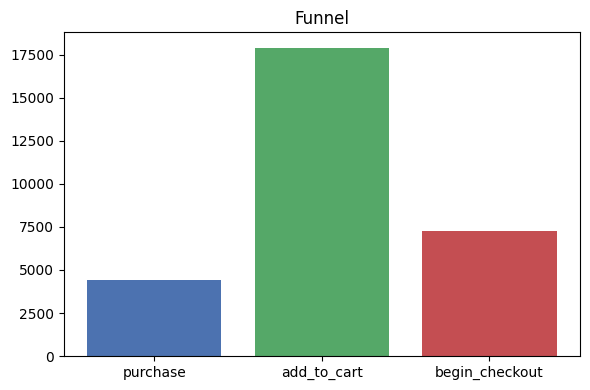

In [54]:

#  Save session data
session_final.to_csv('sessions.csv', index=False)
print('Saved sessions.csv')
#  Funnel plot
plt.figure(figsize=(6, 4))
plt.bar(['purchase', 'add_to_cart', 'begin_checkout'],
        [purchase_sessions, total_sessions,  sessions_with_checkout ],
        color=['#4c72b0', '#55a868', '#c44e52', '#8172b3'])
plt.title('Funnel')
plt.tight_layout()
plt.savefig('funnel_counts_nb.png')
print('Saved funnel image')


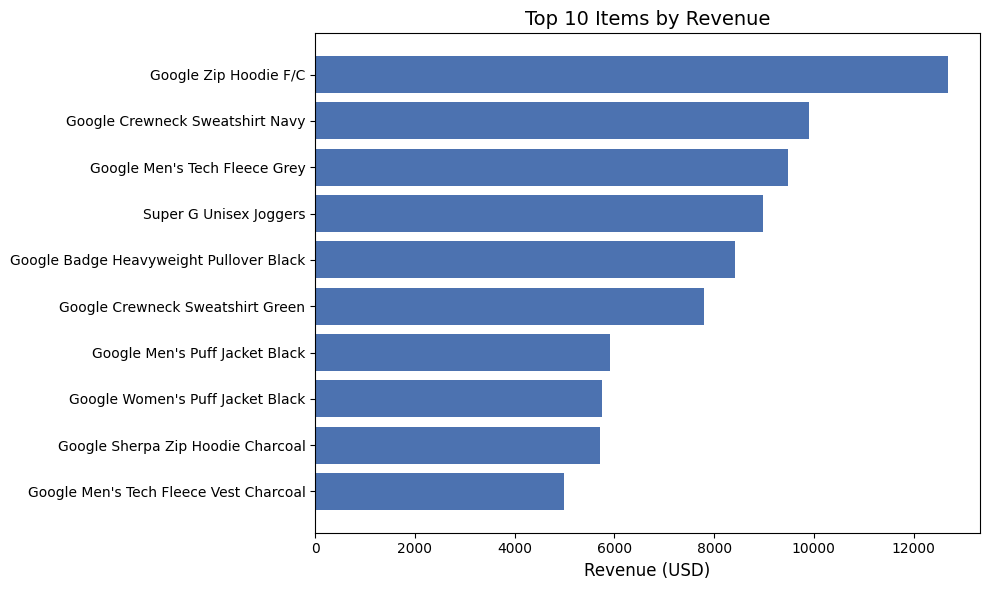

In [ ]:

#  Step 1: Merge purchase events with item details
purchases = events1[events1['type'] == 'purchase'].merge(
    items, left_on='item_id', right_on='id', how='left'
)

#  Step 2: Ensure price column is numeric
price_column = 'price_in_usd' if 'price_in_usd' in purchases.columns else 'price'
purchases[price_column] = pd.to_numeric(purchases[price_column], errors='coerce').fillna(0)

#  Step 3: Aggregate revenue by item name
item_revenue = purchases.groupby('name')[price_column].sum().reset_index()
top_items = item_revenue.sort_values(by=price_column, ascending=False).head(10)

#  Step 4: Plot horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_items['name'], top_items[price_column], color='#4c72b0')
plt.xlabel('Revenue (USD)', fontsize=12)
plt.title('Top 10 Items by Revenue', fontsize=14)
plt.gca().invert_yaxis()  # Highest revenue at top
plt.tight_layout()
plt.savefig('top_items_by_revenue.png')
plt.show()


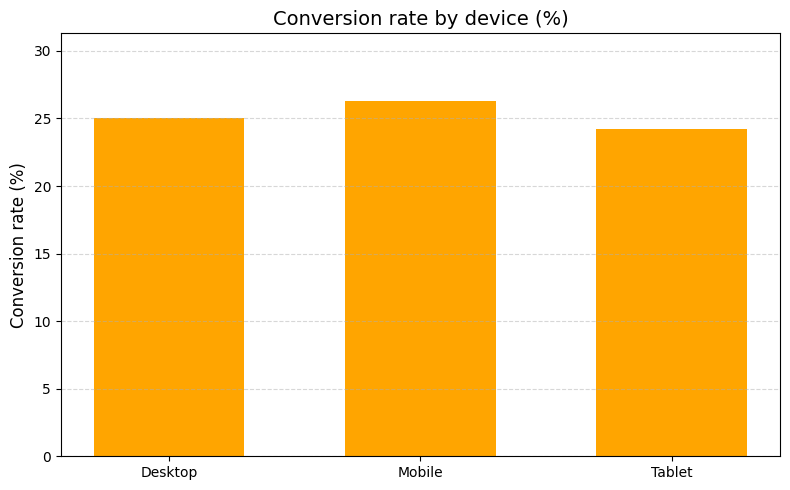

In [ ]:

#  Sample conversion rate data (replace with actual calculations if needed)
conversion_rates = {
    'Desktop': 25.0,
    'Mobile': 26.3,
    'Tablet': 24.2
}

#  Prepare data
devices = list(conversion_rates.keys())
rates = list(conversion_rates.values())

#  Plotting
plt.figure(figsize=(8, 5))
plt.bar(devices, rates, color='orange', width=0.6)
plt.title('Conversion rate by device (%)', fontsize=14)
plt.ylabel('Conversion rate (%)', fontsize=12)
plt.ylim(0, max(rates) + 5)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('conversion_rate_by_device.png')
plt.show()


In [ ]:
#  Top pages
if 'type' in events1.columns:
    top_pages = events1['type'].value_counts().head(10)
    print("Top Pages:\n", top_pages)

Top Pages:
 type
add_to_cart       663305
begin_checkout     75549
purchase           15475
Name: count, dtype: int64


In [ ]:
#  Bounce rate and time-on-page
if 'ga_session_id' in events1.columns and 'item_id' in events1.columns:
    bounce_sessions = events1.groupby('ga_session_id').filter(lambda x: len(x) == 1)
    bounce_rate_value = len(bounce_sessions['ga_session_id'].unique()) / events1['ga_session_id'].nunique()
    print("Bounce Rate:", round(bounce_rate_value * 100, 2), "%")

    avg_time_on_page = events1.groupby('type')['item_id'].mean()
    print("Average Time on Page:\n", avg_time_on_page)

Bounce Rate: 3.46 %
Average Time on Page:
 type
add_to_cart       975.087100
begin_checkout    233.367391
purchase          235.901195
Name: item_id, dtype: float64


In [ ]:
#  Define required funnel steps
required_steps = ['purchase', 'add_to_cart', 'begin_checkout']

#  Check if 'type' column exists and contains all required steps
if 'type' in events1.columns and all(step in events1['type'].unique() for step in required_steps):
    funnel = {step: 0 for step in required_steps}

    #  Loop through each session and count step visits
    for session_id, group in events1.groupby('ga_session_id'):
        visited_steps = set(group['type'].dropna().tolist())
        for step in required_steps:
            if step in visited_steps:
                funnel[step] += 1

    #  Print funnel conversion counts
    print("Funnel Conversion:")
    for step, count in funnel.items():
        print(f"{step}: {count}")

    #  Drop-off analysis between steps
    drop_offs = {}
    for i in range(len(required_steps) - 1):
        current_step = required_steps[i]
        next_step = required_steps[i + 1]
        drop_offs[current_step] = funnel[current_step] - funnel[next_step]

    print("Drop-offs at each stage:")
    for step, count in drop_offs.items():
        print(f"{step} → {required_steps[required_steps.index(step)+1]}: {count}")
else:
    print("Funnel steps not found or missing in 'type' column.")


Funnel Conversion:
purchase: 4411
add_to_cart: 15021
begin_checkout: 7240
Drop-offs at each stage:
purchase → add_to_cart: -10610
add_to_cart → begin_checkout: 7781


In [ ]:
#  Drop-off analysis between funnel steps
drop_offs = {}
for i in range(len(required_steps) - 1):
    current_step = required_steps[i]
    next_step = required_steps[i + 1]
    current_count = funnel.get(current_step, 0)
    next_count = funnel.get(next_step, 0)
    drop_offs[f"{current_step} → {next_step}"] = current_count - next_count

#  Print drop-offs cleanly
print("Drop-offs at each stage:")
for step_pair, count in drop_offs.items():
    print(f"{step_pair}: {count}")


Drop-offs at each stage:
purchase → add_to_cart: -10610
add_to_cart → begin_checkout: 7781


### Description :
- In This project the data analysed on user behavior and conversion performance using session-level event data. 
- It calculates key metrics like bounce rate, session duration, and revenue, and segments users by device type and traffic source. 
- Funnel stages such as add-to-cart, checkout, and purchase are visualized to highlight drop-offs. 
- Conversion rates are compared across devices, top-performing items by revenue are identified and Bounce rate, Drop-offs at each stage are identified 


1. Funnel Chart (Vertical Bar Chart) :
   - It highlights where users drop off in the conversion journey, helping you identify bottlenecks and optimize specific stages for better performance.

2. Top 10 Items by Revenue (Horizontal Bar Chart) :
   - It reveals which items are driving the most revenue, guiding inventory decisions, marketing focus, and promotional strategies.

3. Conversion Rate by Device (Vertical Bar Chart) :
    - It helps you understand which device segments convert best, allowing for tailored UX improvements and device-specific campaign targeting.

